In [2]:
import re
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

In [81]:
# 各フォルダの読み込み
folder_list = glob.glob(r'.\input\spectra_data\*')

# データの区切りを指定（タブ：'\t', コンマ：',', セミコロン：';'）
sep = '[,;\t]'

# excelファイルの保存先のパス
output_path = r'.\output\\'

In [82]:
label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
# label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
# label_list = ['CH3:COOH=0:1', 'CH3:COOH=1:3', 'CH3:COOH=1:1', 'CH3:COOH=3:1', 'CH3:COOH=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'

dataframe_title = '1variable_analysis_data'

data_df = pd.read_excel(dataframe_path + dataframe_title + '.xlsx')
data_df.head()

,Index,raw_peak1,raw_peak2,raw_peak3,raw_peak4,raw_peak5,std_peak1,std_peak2,std_peak3,std_peak4,std_peak5,label
0,CH3-COOH_1-0_01,5103.738329,-190.438947,3683.338417,15008.388339,2495.599180,0.985504,-1.281596,1.603149,2.807891,-1.408493,0
1,CH3-COOH_1-0_02,7812.295705,-194.556679,4414.272363,13674.507873,2396.694976,2.357140,-1.341189,2.553350,3.504776,-1.522716,0
2,CH3-COOH_1-0_03,6766.516954,-197.440682,4061.869953,15787.879885,2984.004149,1.827549,-1.262702,2.205239,4.876685,-0.896542,0
3,CH3-COOH_1-0_04,6495.640211,-140.306765,3963.427044,16377.685418,2759.395509,1.690375,-1.186554,1.991127,2.524528,-1.136014,0
4,CH3-COOH_1-0_05,7921.366032,-250.325583,4436.995675,15268.477283,2591.922039,2.412374,-1.365968,2.478621,3.846731,-1.314570,0


In [83]:
# 特徴量とラベルの分離
data_label = data_df['label']
data_df = data_df.drop(['Index', 'label'], axis=1)

In [157]:
analysis_data_df = data_df[['std_peak5']]

# Linear SVC

## クロスバリデーションでの予測

In [158]:
# kernel:rbf(ガウス関数) その他：linear(線形回帰)、poly(多項式展開)、sigmoidなどがある
def linear_svc(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = LinearSVC(C=C, max_iter=5000)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-pack

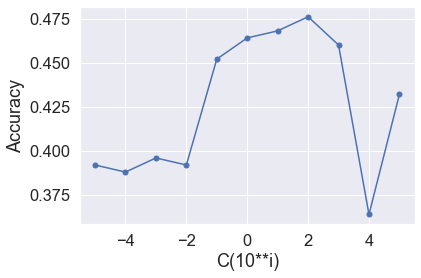

In [159]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = linear_svc(10**i, analysis_data_df, data_label)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [160]:
cm_linear_svc, accuracy_linear_svc = linear_svc(100, analysis_data_df, data_label)
print('Accuracy:', accuracy_linear_svc)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.472


<AxesSubplot:>

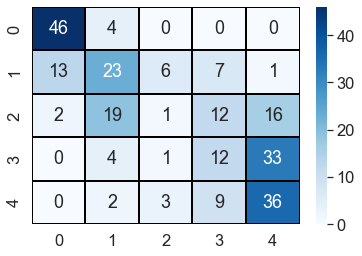

In [161]:
sns.set(font_scale=1.5)
sns.heatmap(cm_linear_svc, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データでの予測

In [100]:
def train_linear_svc(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    svm_model = LinearSVC(C=C, max_iter=5000)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [109]:
train_cm_linear_svc, train_accuracy_linear_svc = train_linear_svc(0.1, analysis_data_df, data_label)
print('Accuracy:', train_accuracy_linear_svc)

Accuracy: 0.4


c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<AxesSubplot:>

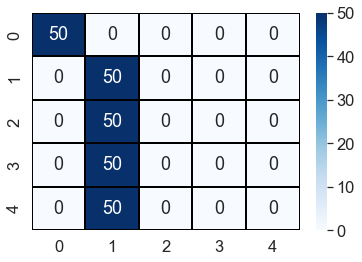

In [110]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_linear_svc, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Perceptron

## クロスバリデーションでの予測

In [103]:
def perceptron(data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        per_model = Perceptron()
        per_model.fit(train_x, train_y)
        y_pred = per_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [104]:
cm_per, accuracy_per = perceptron(analysis_data_df, data_label)
print('Accuracy:', accuracy_per)

Accuracy: 0.224


<AxesSubplot:>

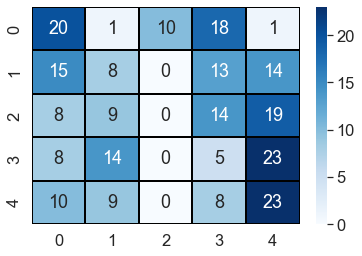

In [105]:
sns.set(font_scale=1.5)
sns.heatmap(cm_per, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Logistic Regression

In [106]:
def logistic(data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        log_model = LogisticRegression()
        log_model.fit(train_x, train_y)
        y_pred = log_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [107]:
cm_log, accuracy_log = perceptron(analysis_data_df, data_label)
print('Accuracy:', accuracy_log)

Accuracy: 0.224


<AxesSubplot:>

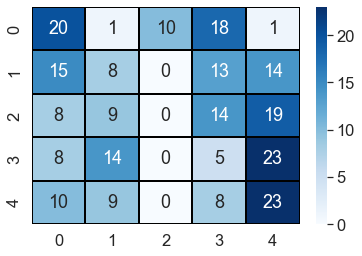

In [108]:
sns.set(font_scale=1.5)
sns.heatmap(cm_log, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# LDA

In [27]:
# label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
# label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1',
              'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1',
              'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'

dataframe_title = 'CH3_COOH_NH2_standard_df'
test_dataframe_title = 'CH3_COOH_OH_NH2_standard_df'
data_df = pd.read_pickle(dataframe_path + dataframe_title + '.pkl')
test_data_df = pd.read_pickle(dataframe_path + test_dataframe_title + '.pkl')

# 特徴量とラベルの分離
data_label = data_df['label']
test_data_label = test_data_df['label']
data_df = data_df.drop('label', axis=1)
test_data_df = test_data_df.drop('label', axis=1)

In [28]:
def lda_2D_plot(df, df_label, test_df):
    lda = LDA(n_components=2)
    X_r2 = lda.fit(df, df_label).transform(test_df)

    color_list = ['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'gold', 'grey', 'black', 'lime', 'navy', 'pink', 'brown']

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

    for i in range(np.unique(test_data_label).size):
        plt.scatter(X_r2[test_data_label == i, 0], X_r2[test_data_label == i, 1],
        c=color_list[i], label=label_list[i])

    # ldaの結果をデータフレーム化
    lda_result_df = pd.DataFrame(X_r2)
    lda_result_df.columns = ['LDA1', 'LDA2']
    lda_result_df['label'] = test_data_label.values

    # 重みベクトルの取得
    # lda_weight_vec_df = pd.DataFrame(lda.coef_, columns=data_df.columns, index=label_list)

    plt.xlabel('LDA1')
    plt.ylabel('LDA2')
    plt.legend(loc='best')
    plt.show()

    return lda_result_df

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


explained variance ratio (first two components): [0.68334055 0.26513247]


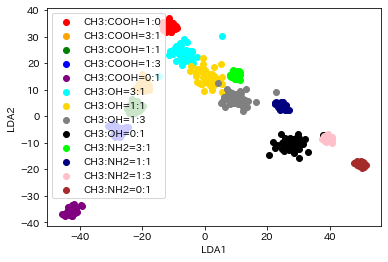

In [29]:
standard_lda_result_df = lda_2D_plot(data_df, data_label, test_data_df)

In [30]:
graph_title = 'standard_lda_result_OH'
standard_lda_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)